Get data.
try multiple clustering algorithms and plot the profiles

In [1]:
import pandas, seaborn, numpy, pyensembl, scipy, os

import sklearn, sklearn.cluster
import statsmodels, statsmodels.stats, statsmodels.stats.multitest

import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':20, 'ytick.labelsize':20, 'figure.figsize':(8, 4), 'axes.labelsize':20})

# 0. user-defined variables

In [2]:
#! drangajokull
home_dir = '/home/adrian/'

#! necio5
#dorothea_regulons_dir = '/Users/adrian/databases/dorothea/regulons/'
#scratch_dir = '/Users/adrian/scratch/'

In [3]:
dorothea_regulons_dir = home_dir + 'databases/dorothea/regulons/'
up_file = home_dir + 'gd15/hi/research/osteo/results/up_and_down_DEGs/up.csv'
overall_file = home_dir + 'gd15/hi/research/osteo/results/up_and_down_DEGs/all_zscore.csv'
regulons_results_file = home_dir + 'gd15/hi/research/osteo/results/regulons/regulons_up.csv'
scratch_dir = home_dir + 'scratch/'

days = [3, 6, 9, 16, 28]

# 1. read data

## 1.1. read expression data

In [4]:
expression = pandas.read_csv(up_file, index_col=0)

print(expression.shape)
expression.head()

(571, 5)


,Day_3,Day_6,Day_9,Day_16,Day_28
ENSG00000106538,-1.041366,-0.637951,0.702163,-0.637951,1.615104
ENSG00000257017,-1.184086,-0.713912,0.881069,-0.438877,1.455807
ENSG00000112936,-1.270523,-0.691817,0.932816,-0.353296,1.382822
ENSG00000129988,-1.051535,-1.051535,1.257512,-0.229036,1.074594
ENSG00000133048,-1.784914,0.207845,1.236076,0.474520,-0.133526


In [5]:
overall_expression = pandas.read_csv(overall_file, index_col=0)

print(overall_expression.shape)
overall_expression.head()

(61881, 5)


,Day_3,Day_6,Day_9,Day_16,Day_28
ENSG00000000003,-1.652464,0.509438,1.011249,0.765363,-0.633587
ENSG00000000005,NaN,NaN,NaN,NaN,NaN
ENSG00000000419,0.388132,-0.813199,-1.316938,1.555271,0.186734
ENSG00000000457,0.500000,0.500000,0.500000,0.500000,-2.000000
ENSG00000000460,1.648206,-0.777687,-0.777687,0.684855,-0.777687


## 1.2. read TF-gene interactions

In [6]:
regulons = {}
regulon_files = os.listdir(dorothea_regulons_dir)
for file in regulon_files:
    TF_name = file.split('.txt')[0]
    df = pandas.read_csv(dorothea_regulons_dir+file, sep='\t', header=None, names=['target'])
    targets = df['target'].to_list()
    regulons[TF_name] = targets

In [7]:
annotation = pyensembl.EnsemblRelease(86) # better matching than version 100
annotation

EnsemblRelease(release=86, species='homo_sapiens')

In [8]:
# 12 missing for annotation 75
# 9 missing for annotation 86
# 11 missing for annotation 100
# 11 missing for annotation 102
up_genes = expression.index.to_list()
rosetta_up_genes = {}

missing = 0
for ensembl in up_genes:
    try:
        gene_name = annotation.gene_by_id(ensembl).gene_name
        rosetta_up_genes[ensembl] = gene_name
    except:
        missing = missing + 1
        print('Missing #{}. {} not found'.format(missing, ensembl))

Missing #1. ENSG00000274619 not found
Missing #2. ENSG00000278843 not found
Missing #3. ENSG00000282854 not found
Missing #4. ENSG00000283009 not found
Missing #5. ENSG00000283106 not found
Missing #6. ENSG00000263238 not found
Missing #7. ENSG00000275482 not found
Missing #8. ENSG00000273707 not found
Missing #9. ENSG00000282147 not found


In [9]:
# define M, the number of target genes in Dorothea regulons
all_targets = []
for TF in regulons:
    for element in regulons[TF]:
        all_targets.append(element)
M = len(list(set(all_targets)))
print('found {} targets'.format(M))

found 20295 targets


# 2. format data

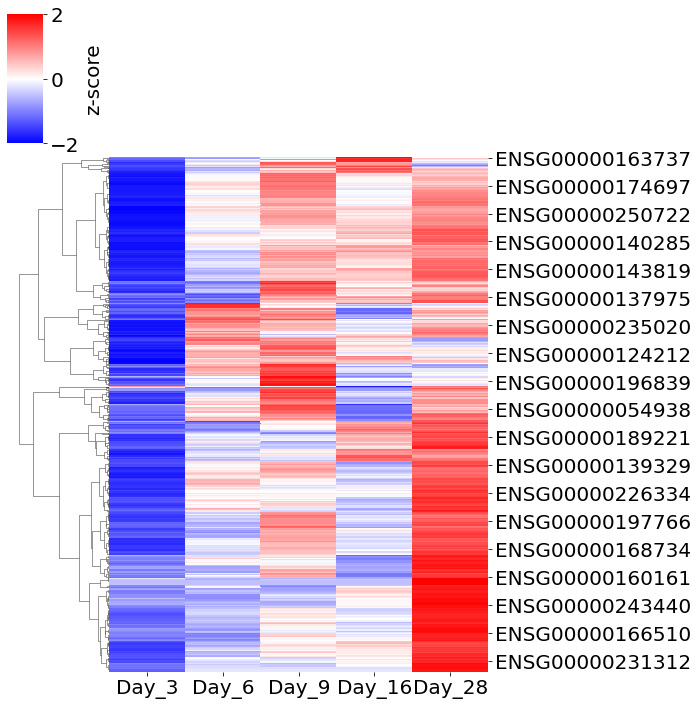

In [10]:
linkage_method = 'complete'
distance_metric = 'cosine'

seaborn.clustermap(expression, cmap='bwr', vmin=-2, vmax=2, col_cluster=False, method=linkage_method, metric=distance_metric,  cbar_kws={'label':'z-score'})

In [11]:
x = expression.to_numpy()
x

array([[-1.04136554, -0.63795097,  0.70216321, -0.63795097,  1.61510426],
       [-1.18408635, -0.71391191,  0.88106904, -0.43887749,  1.45580671],
       [-1.27052345, -0.6918175 ,  0.93281551, -0.35329621,  1.38282165],
       ...,
       [-1.39939766, -0.23503204,  0.6681201 ,  1.50128656, -0.53497696],
       [ 0.78501372, -0.03377595, -0.03377595, -1.79471421,  1.0772524 ],
       [ 0.61327685, -0.6199899 ,  0.35890899, -1.59888878,  1.24669284]])

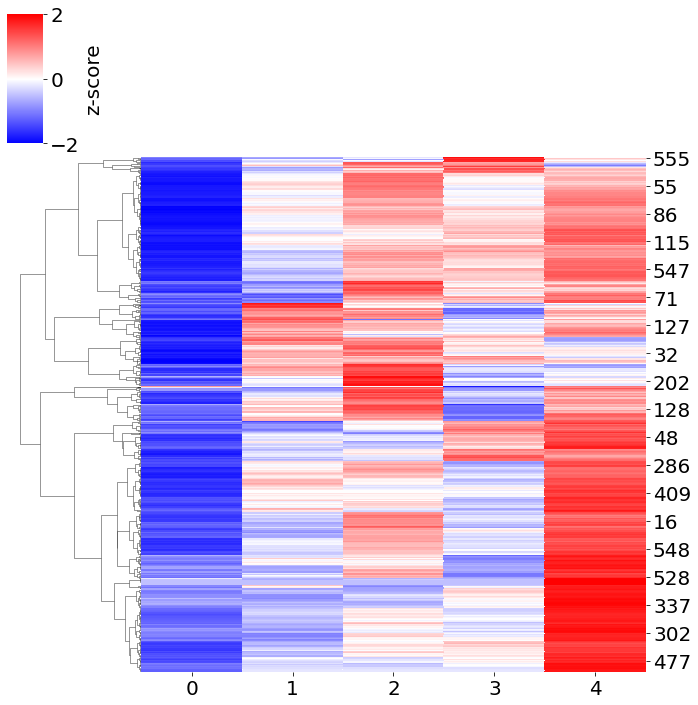

In [12]:
seaborn.clustermap(x, cmap='bwr', vmin=-2, vmax=2, col_cluster=False, method=linkage_method, metric=distance_metric,  cbar_kws={'label':'z-score'})

# 3. define partition range

In [13]:
number_elements = expression.shape[0]
fine = int(number_elements/5)
coarse = int(number_elements/20)
print(coarse, fine)
k_range = range(coarse, fine+1)
# k_range = range(35, 45)

28 114


# 4. learning

In [14]:
###
### informative cell about hypergeometric test
###

# M is the population size
# n is the number of successes in the population 
# N is the sample size (previously n)
# x is still the number of drawn “successes”

# M is the total number of targets in Dorothea
# n is the number of targets of a particular TF in Dorothea
# N is the size of DETs
# x is the number of DETs that are targets of a particular TF

M = 20000
n = 200

N = 1000
xint = 20 # 10 would be the same ratio

print('p-value <= ' + str(xint) + ': ' + str(scipy.stats.hypergeom.cdf(xint, M, n, N)))
print('p-value >= ' + str(xint)  + ': ' + str(scipy.stats.hypergeom.sf(xint-1, M, n, N)))

p-value <= 20: 0.9989104333089479
p-value >= 20: 0.0025301883214874205


In [15]:
log = open('log.txt', 'w')

In [16]:
def tf_enrichment(k, labels):
    
    domain = []; controllers = [] 
    regulons_membership = {}; regulons_activity = {}; regulons_quant = {}
    cluster_id_map = {}
    
    figures_dir = scratch_dir + str(k) + '/'
    if os.path.exists(figures_dir) == False:
        os.mkdir(figures_dir)
    
    for ki in range(k): ### iteration over clusters in a given partition
        
        indices = numpy.where(labels == ki)[0]
        log.write('\nCluster c{} with {} gene indices: {}\n'.format(ki, len(indices), indices))
        cluster = expression.iloc[indices, :]
        cluster_average = cluster.mean().values

        ###
        ### plotting
        ###
#         for gene in cluster.index:
#             matplotlib.pyplot.plot(days, cluster.loc[gene, :], 'o-')
#         matplotlib.pyplot.xlabel('Time (day)')
#         matplotlib.pyplot.ylabel('zscore')
#         matplotlib.pyplot.grid(alpha=0.5, ls=':')
#         matplotlib.pyplot.ylim([-2, 2])
#         matplotlib.pyplot.xlim(([0, 29]))
#         matplotlib.pyplot.title('k={} | c{}'.format(k, ki))
#         matplotlib.pyplot.tight_layout()
#         matplotlib.pyplot.savefig(figures_dir+'c{}.pdf'.format(ki))
#         matplotlib.pyplot.clf()
        
        ###
        ### convert cluster ENSEMBL ids into gene names
        ###
        cluster_ensembl_ids = expression.index[indices]
        cluster_gene_names = []
        for ensembl in cluster_ensembl_ids:
            try:
                gene_name = rosetta_up_genes[ensembl]
                cluster_gene_names.append(gene_name)
                cluster_id_map[gene_name] = ensembl
            except:
                log.write('ENSEMBL ID {} lost.\n'.format(ensembl))
        log.write('{}/{} genes recovered.\n'.format(len(cluster_gene_names), len(cluster_ensembl_ids)))

        ###
        ### enrichment
        ###

        # define N, the size of the regulon
        N = len(cluster_gene_names)

        # get all TFs regulating each target gene
        putative_TFs = []
        for gene_name in cluster_gene_names:
            for TF in regulons:
                if gene_name in regulons[TF]:
                    putative_TFs.append(TF)
        putative_regulators = list(set(putative_TFs))
        putative_regulators.sort()
        log.write('all possible regulators of this cluster:{}\n'.format(len(putative_regulators)))

        # hypergeometric test for putative regulators
        p_values_uncorrected = []
        hits_tracker = [] # store tuples of information
        for putative_regulator in putative_regulators:

            # define n, the number of targets of that particular TF in Dorothea
            global_TF_targets = regulons[putative_regulator]
            n = len(global_TF_targets)

            # define x, the number of DETs that are targets of that particular TF
            intersect = list(set(cluster_gene_names) & set(global_TF_targets))
            x = len(intersect)

            # make sure that the regulon has at least two target genes for a given TF, otherwise, don't waste hypothesis correction
            if x >= 2:
                pvalue = scipy.stats.hypergeom.sf(x-1, M, n, N)
                p_values_uncorrected.append(pvalue)
                
                # compute activity
                intersect_ensembl = [cluster_id_map[element] for element in intersect]
                activity = expression.loc[intersect_ensembl, :].mean().values
                
                # prepare information in a tuple
                tracking_tuple = (putative_regulator, n, M, x, N, round(x/N, 3), intersect, activity)
                hits_tracker.append(tracking_tuple)

        # multiple correction for all putative regulators of this cluster: Benjamini–Hochberg correction
        alternative, corrected_p_values = statsmodels.stats.multitest.fdrcorrection(p_values_uncorrected, alpha=0.1)
        for i in range(len(alternative)):
            if alternative[i] == True:
                
                # compute correlation: first TF, then just get the activity of those target genes, not the cluster
                
                # TF
                recovered_ids = annotation.genes_by_name(hits_tracker[i][0])
                if len(recovered_ids) == 1:
                    tf_id = recovered_ids[0].gene_id
                else:
                    raise ValueError('two IDs found for a given TF')
                try:
                    tf_trend = overall_expression.loc[tf_id, :].values
                except:
                    log.write('\t TF {} not found in overall expression\n'.format(tf_id))
                    tf_trend = [numpy.NAN]
                
                if numpy.isnan(tf_trend).any() == True:
                    pcc = 0
                else:
                    pcc, pvalue = scipy.stats.pearsonr(tf_trend, hits_tracker[i][7])
                
                if pcc > 0.8:
                    log.write('\t HIT: {} {}\n'.format(round(pcc, 3), hits_tracker[i][:-1]))
                    
                    controllers.append(hits_tracker[i][0])
                    for element in hits_tracker[i][6]:
                        domain.append(element)
                    
                    # merging if necessary
                    if hits_tracker[i][0] not in regulons_membership:
                        regulons_membership[hits_tracker[i][0]] = hits_tracker[i][6]
                        regulons_quant[hits_tracker[i][0]] = [(pcc, corrected_p_values[i])]
                    else:
                        for element in hits_tracker[i][6]:
                            regulons_membership[hits_tracker[i][0]].append(element)
                        regulons_quant[hits_tracker[i][0]].append((pcc, corrected_p_values[i]))
                        log.write('\t merged two regulons that shared TF {}'.format(hits_tracker[i][0]))
                        
    # compute the domain
    unique_domain = list(set(domain))
    domain_size = len(unique_domain)
    
    unique_controllers = list(set(controllers))
    controllers_size = len(unique_controllers)
    
    # compute regulon activity
    for TF in regulons_membership:
        targets = regulons_membership[TF]
        targets_ensembl = [cluster_id_map[gene_name] for gene_name in targets]
        activity = expression.loc[targets_ensembl, :].mean().values
        regulons_activity[TF] = activity
                
    return domain_size, controllers_size, regulons_membership, regulons_activity, regulons_quant

In [17]:
###
### iteration over k
###

p_ss = []; p_khi = []; p_dbi = []; p_dom = []; p_control = []; p_quant = []
p_rm = []; p_ra = []

for k in k_range:
    
    log.write('WORKING WITH k={}\n'.format(k))

    partition = sklearn.cluster.AgglomerativeClustering(n_clusters=k, affinity='cosine', linkage='complete').fit(x)
    labels = partition.labels_

    ss = sklearn.metrics.silhouette_score(x, labels, metric='cosine')
    khi = sklearn.metrics.calinski_harabasz_score(x, labels)
    dbi = sklearn.metrics.davies_bouldin_score(x, labels)

    p_ss.append(ss)
    p_khi.append(khi)
    p_dbi.append(dbi)
    
    domain_size, controllers_size, regulons_membership, regulons_activity, regulons_quant = tf_enrichment(k, labels)
    
    p_dom.append(domain_size)
    p_control.append(controllers_size)
    
    p_rm.append(regulons_membership)
    p_ra.append(regulons_activity)
    p_quant.append(regulons_quant)

In [18]:
log.close()

In [19]:
# need to do with K means and all other methods present in sklearn that are inductive (?)

## 4.1. plot learned results

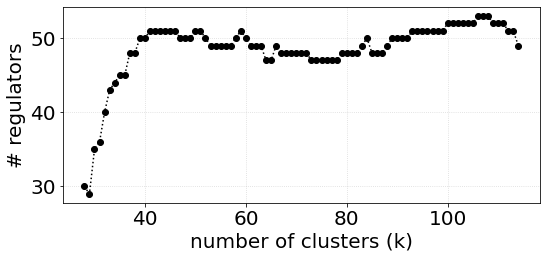

In [20]:
matplotlib.pyplot.plot(k_range, p_control, 'ok')
matplotlib.pyplot.plot(k_range, p_control, ':', color='black')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('number of clusters (k)')
matplotlib.pyplot.ylabel('# regulators')
matplotlib.pyplot.tight_layout()

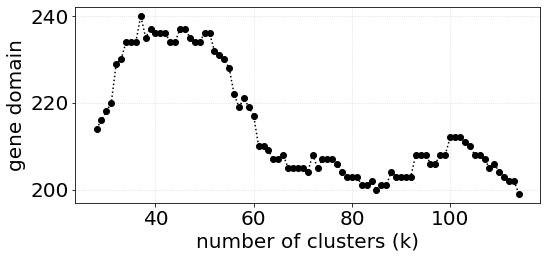

In [21]:
matplotlib.pyplot.plot(k_range, p_dom, 'ok')
matplotlib.pyplot.plot(k_range, p_dom, ':', color='black')
matplotlib.pyplot.xlabel('number of clusters (k)')
matplotlib.pyplot.ylabel('gene domain')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.tight_layout()

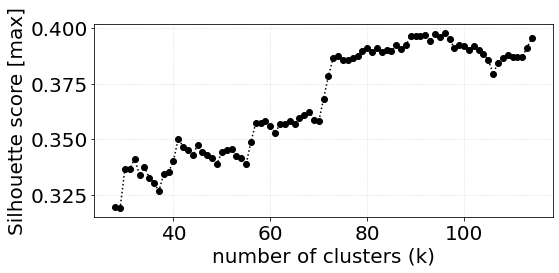

In [22]:
matplotlib.pyplot.plot(k_range, p_ss, 'ok')
matplotlib.pyplot.plot(k_range, p_ss, ':', color='black')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('number of clusters (k)')
matplotlib.pyplot.ylabel('Silhouette score [max]')
matplotlib.pyplot.tight_layout()

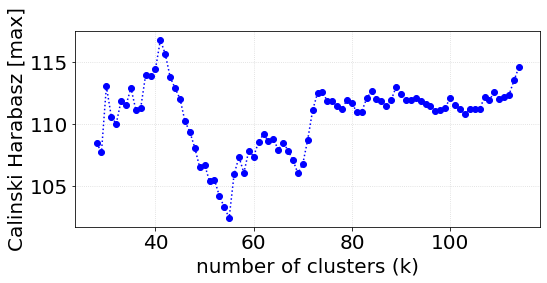

In [23]:
matplotlib.pyplot.plot(k_range, p_khi, 'ob')
matplotlib.pyplot.plot(k_range, p_khi, ':', color='blue')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('number of clusters (k)')
matplotlib.pyplot.ylabel('Calinski Harabasz [max]')
matplotlib.pyplot.tight_layout()

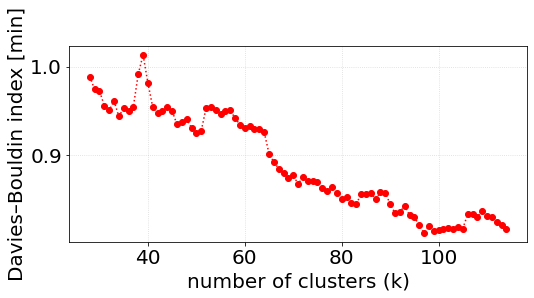

In [24]:
matplotlib.pyplot.plot(k_range, p_dbi, 'or')
matplotlib.pyplot.plot(k_range, p_dbi, ':', color='red')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('number of clusters (k)')
matplotlib.pyplot.ylabel('Davies–Bouldin index [min]')
matplotlib.pyplot.tight_layout()

# 5. store results

In [25]:
for i in range(len(k_range)):
    print(i, k_range[i])
    
    if k_range[i] == 41:
        print('\t storing')
        regulons_membership = p_rm[i]
        regulons_activity = p_ra[i]
        quant = p_quant[i]

0 28
1 29
2 30
3 31
4 32
5 33
6 34
7 35
8 36
9 37
10 38
11 39
12 40
13 41
	 storing
14 42
15 43
16 44
17 45
18 46
19 47
20 48
21 49
22 50
23 51
24 52
25 53
26 54
27 55
28 56
29 57
30 58
31 59
32 60
33 61
34 62
35 63
36 64
37 65
38 66
39 67
40 68
41 69
42 70
43 71
44 72
45 73
46 74
47 75
48 76
49 77
50 78
51 79
52 80
53 81
54 82
55 83
56 84
57 85
58 86
59 87
60 88
61 89
62 90
63 91
64 92
65 93
66 94
67 95
68 96
69 97
70 98
71 99
72 100
73 101
74 102
75 103
76 104
77 105
78 106
79 107
80 108
81 109
82 110
83 111
84 112
85 113
86 114


In [26]:
regulons_activity

{'PRRX2': array([-1.64755403, -0.29197976,  0.81521397,  0.32527099,  0.79904882]),
 'JDP2': array([-1.42267915, -0.58609522,  0.40850514,  0.27368056,  1.32658867]),
 'RORB': array([-1.20409554, -0.93363027, -0.06760523,  0.80170687,  1.40362417]),
 'NFATC4': array([-1.37507955,  0.79053045,  1.25782851, -0.08812128, -0.58515813]),
 'POU6F1': array([-1.27172733,  0.60348254,  1.52669961, -0.37751511, -0.4809397 ]),
 'ZFP90': array([-1.43720234,  0.50260301,  1.50914835, -0.17403359, -0.40051544]),
 'TSC22D1': array([-1.2366383 , -0.33943717,  0.00211586, -0.10613974,  1.68009936]),
 'TBX19': array([-1.16555099,  0.34147819,  0.90049518, -1.16555099,  1.08912861]),
 'TGIF1': array([-1.48373774, -0.07117083,  0.54108335, -0.37443189,  1.38825711]),
 'CREBL2': array([-1.76313131,  0.81705185, -0.07030546, -0.03813774,  1.05452266]),
 'NKX3-2': array([-1.87839436,  0.62828209, -0.01538453,  0.3194383 ,  0.94605849]),
 'PLAG1': array([-1.76313131,  0.81705185, -0.07030546, -0.03813774,  1.

In [27]:
with open(regulons_results_file, 'w') as f:
    
    f.write('TF\tRegulon size\tTarget genes\tTF-targets PCC\tEnrichment corrected P value\tDay 3\tDay 6\tDay 9\tDay 16\t Day 28\n')
    
    for tf in regulons_membership:
        
        f.write(tf)
        f.write('\t{}'.format(len(regulons_membership[tf])))
        
        gene_string = ', '.join(regulons_membership[tf])
        f.write('\t{}'.format(gene_string))
        
        # pcc and correcte P value
        #for element in quant[tf]:
        mean_pcc = numpy.mean([element[0] for element in quant[tf]])
        mean_pvalue = numpy.mean([element[1] for element in quant[tf]])
        print(tf, mean_pcc, mean_pvalue)
        f.write('\t{}\t{:.2e}'.format(round(mean_pcc, 3), round(mean_pvalue, 4)))
        
        # activity
        for element in regulons_activity[tf]:
            f.write('\t{}'.format(round(element, 3)))
        
        f.write('\n')

PRRX2 0.8418027096757 0.042796600386172105
JDP2 0.9360686037960791 0.04496160918618047
RORB 0.9414513401203644 0.07006714444863202
NFATC4 0.9018844183865491 0.061036795763117956
POU6F1 0.8285361001303123 0.05299166714010088
ZFP90 0.8923785965493767 0.06787611051328156
TSC22D1 0.9402872257573914 0.050579691854766705
TBX19 0.9681993686750607 0.06378292172538172
TGIF1 0.9049189336677708 0.06293730368522257
CREBL2 0.816798940981748 0.05294326797056116
NKX3-2 0.9467628891164984 0.04869640180298365
PLAG1 0.9215657460771383 0.036601918094228136
FOXC1 0.8999440182584092 0.0357309376939664
ZNF521 0.9058976777650527 0.035098500318978335
DBP 0.8644594845986424 0.09065581145209477
ARID5B 0.8840793018474672 0.039440010752589544
ZNF581 0.8656407709105881 0.07949117483318507
ARID5A 0.9154819499362756 0.07770049229053926
ATF4 0.9774056450433519 0.005870326702898251
FOS 0.9473622860577045 0.05417787102769691
OSR2 0.8865578388757395 0.018050466013677068
YBX3 0.9268597635594349 0.05349791422690991
ZNF22 

In [28]:
all_tfs = []; all_targets = []
for TF in regulons_membership:
    all_tfs.append(TF)
    
    for element in regulons_membership[TF]:
        all_targets.append(element)
    
print('all TFs: {}'.format(len(list(set(all_tfs)))))
print('all targets: {}'.format(len(list(set(all_targets)))))

all TFs: 51
all targets: 236


In [29]:
riffraff = []
selected = ['ZNF521', 'FOXC1', 'PRRX2', 'TGIF1', 'ARID5B'] # 0.491525
#selected = ['ZNF521', 'FOXC1', 'PRRX2', 'TGIF1', 'ARID5B', 'OSR2'] # 0.54237
for sel in selected:
    for element in regulons_membership[sel]:
        riffraff.append(element)
print(len(list(set(riffraff)))/236)

0.4915254237288136
